The problem: How to classify stellar objects based on their spectral characteristics.

https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
# Import data
df_1 = pd.read_csv('star_classification.csv')

* **obj_ID** = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
* **alpha** = Right Ascension angle (at J2000 epoch)
* **delta** = Declination angle (at J2000 epoch)
* **u** = Ultraviolet filter in the photometric system
* **g** = Green filter in the photometric system
* **r** = Red filter in the photometric system
* **i** = Near Infrared filter in the photometric system
* **z** = Infrared filter in the photometric system
* **run_ID** = Run Number used to identify the specific scan
* **rerun_ID** = Rerun Number to specify how the image was processed
* **cam_col** = Camera column to identify the scanline within the run
* **field_ID** = Field number to identify each field
* **spec_obj_ID** = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
* **class** = object class (galaxy, star or quasar object)
* **redshift** = redshift value based on the increase in wavelength
* **plate** = plate ID, identifies each plate in SDSS
* **MJD** = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
* **fiber_ID** = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


In [4]:
# Quick look
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


There's some dense scientific language in the variable descriptions, but some Googling helps. 

* Alpha and Delta represent an object's coordinates in the sky, as seen from Earth. We can delete these.
* run_ID, rerun_ID, cam_col, field_ID, fiber_ID, and plate are all related to operating the devices that captured the data. We can also delete these.
* Finally, MJD is a number that represents how many days have passed since midnight on November 17, 1858--it is another method of recording when the photo was taken. We can also delete this.

In [5]:
df = df.drop(['obj_ID', 'alpha', 'delta', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'plate', 'MJD', 'fiber_ID'], axis=1)

In [6]:
# Checking for nulls and looking at basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   u            100000 non-null  float64
 1   g            100000 non-null  float64
 2   r            100000 non-null  float64
 3   i            100000 non-null  float64
 4   z            100000 non-null  float64
 5   spec_obj_ID  100000 non-null  float64
 6   class        100000 non-null  object 
 7   redshift     100000 non-null  float64
dtypes: float64(7), object(1)
memory usage: 6.1+ MB


In [29]:
df.describe()

,u,g,r,i,z,spec_obj_ID,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000
mean,21.980468,20.531387,19.645762,19.084854,18.668810,5.783882e+18,0.576661
std,31.769291,31.750292,1.854760,1.757895,31.728152,3.324016e+18,0.730707
min,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,2.995191e+17,-0.009971
25%,20.352353,18.965230,18.135828,17.732285,17.460677,2.844138e+18,0.054517
50%,22.179135,21.099835,20.125290,19.405145,19.004595,5.614883e+18,0.424173
75%,23.687440,22.123767,21.044785,20.396495,19.921120,8.332144e+18,0.704154
max,32.781390,31.602240,29.571860,32.141470,29.383740,1.412694e+19,7.011245


There is one anomalous row with -9999 for its u, g, and z values. I replaced those values with the average for stars instead.

In [38]:
df.iloc[79543]

u                    -9999
g                    -9999
r                  18.1656
i                  18.0167
z                    -9999
spec_obj_ID    3.73128e+18
class                 STAR
redshift       8.93416e-05
Name: 79543, dtype: object

In [50]:
star_avg = df.loc[df['class']=='STAR'].mean()

df.loc[79543, 'u'] = star_avg['u']
df.loc[79543, 'g'] = star_avg['g']
df.loc[79543, 'z'] = star_avg['z']

In [51]:
df.describe()

,u,g,r,i,z,spec_obj_ID,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000
mean,22.080670,20.631568,19.645762,19.084854,18.768979,5.783882e+18,0.576661
std,2.251059,2.037379,1.854760,1.757895,1.765975,3.324016e+18,0.730707
min,10.996230,10.498200,9.822070,9.469903,9.612333,2.995191e+17,-0.009971
25%,20.352430,18.965245,18.135828,17.732285,17.460900,2.844138e+18,0.054517
50%,22.179135,21.099835,20.125290,19.405145,19.004595,5.614883e+18,0.424173
75%,23.687440,22.123767,21.044785,20.396495,19.921120,8.332144e+18,0.704154
max,32.781390,31.602240,29.571860,32.141470,29.383740,1.412694e+19,7.011245


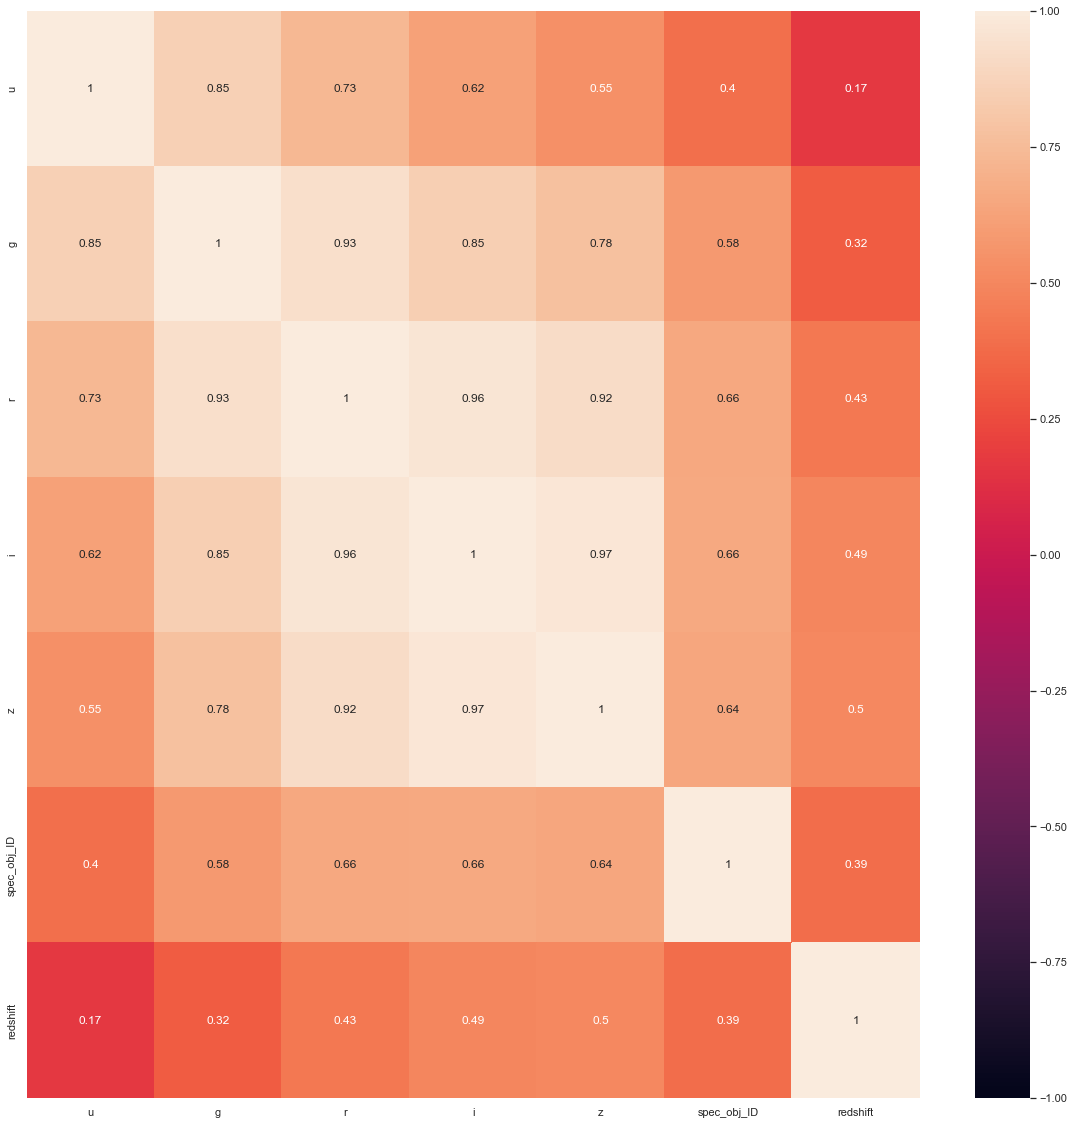

In [52]:
plt.figure(figsize=(20, 20))
sns.set_theme()
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

We can see relatively high correlation between each point of measurement on the wavelength spectrum and its nearest neighbors, which makes sense. The fact that *i* and *z* are the closest is unsurprising, since they are measurements of near-infrared and infrared spectra.

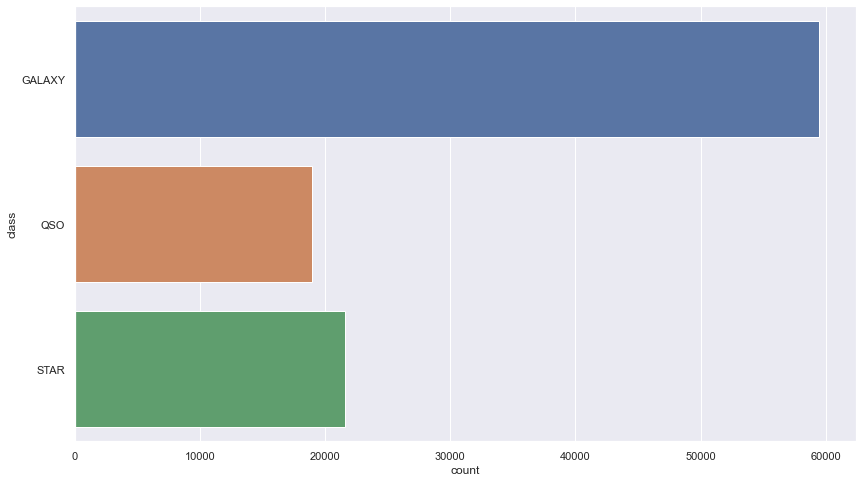

In [53]:
# Looking at distribution of classes 
plt.figure(figsize=(14, 8))
sns.countplot(y="class", data=df)

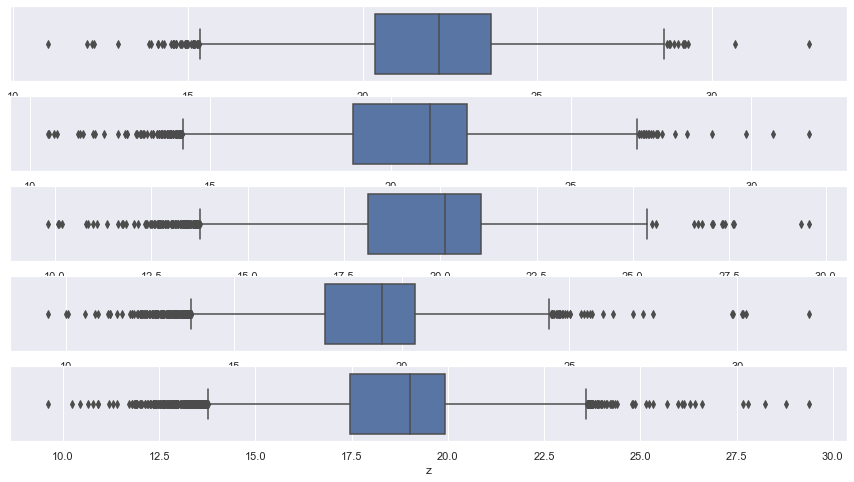

In [78]:
# Comparing distributions of photometrics
fig, axs = plt.subplots(5, 1, figsize=(15, 8))
sns.boxplot(ax=axs[0], x='u', data=df)
sns.boxplot(ax=axs[1], x='g', data=df)
sns.boxplot(ax=axs[2], x='r', data=df)
sns.boxplot(ax=axs[3], x='i', data=df)
sns.boxplot(ax=axs[4], x='z', data=df)

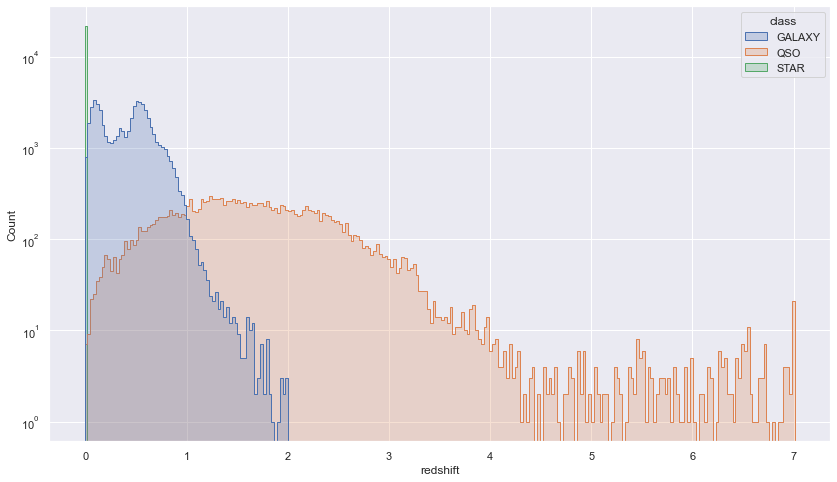

In [17]:
# Class breakdown of redshift
plt.figure(figsize=(14, 8))
sns.histplot(data=df, x="redshift", hue='class', log_scale=[0, 10], element='step')

In [21]:
# Separating out target variable
X = df.drop(['class'], axis=1)
y = df['class']

# Splitting into stratified train and test sets, due to class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=df['class'])

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
# Create and fit classifier
rfclf = RandomForestClassifier()
rfclf.fit(X_train, y_train)

# Run predictions on training and validation sets
rf_train_preds = rfclf.predict(X_train)
rf_test_preds = rfclf.predict(X_test)

# Calculating accuracy of train predictions
print(f"The accuracy of the train set predictions is {round((y_train == rf_train_preds).mean() * 100, 2)}%.")

# Calculating accuracy of validation predictions
print(f"The accuracy of the test set predictions is {round((y_test == rf_test_preds).mean() * 100, 2)}%.")

The accuracy of the train set predictions is 100.0%.
The accuracy of the validation set predictions is 98.0%.


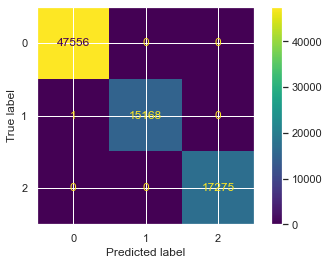

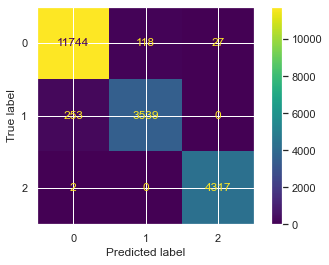

In [83]:
# Create confusion matrices
train_cm = metrics.confusion_matrix(y_train, rf_train_preds)
test_cm = metrics.confusion_matrix(y_test, rf_test_preds)

# Display confusion matrices
metrics.ConfusionMatrixDisplay(train_cm).plot()
metrics.ConfusionMatrixDisplay(test_cm).plot()

In [80]:
# one more